# Module 6: Clustering Analysis and Scatterplot Visualizations

In this module, I’ll explore clustering techniques and how to visualize them effectively.  
The dataset used is **`nigerian-songs.csv`**, which contains various song attributes.  

Here’s what this notebook covers:
- A short overview of the dataset.
- Application of different clustering algorithms (KMeans, DBSCAN, and Agglomerative Clustering).
- Visual exploration of results using Matplotlib, Seaborn, and Plotly.
- A brief comparison and interpretation of the results.




## Dataset Overview

The dataset **`nigerian-songs.csv`** includes metadata and numerical features describing various Nigerian songs.  
For clustering, we’ll focus on numeric columns — such as tempo, loudness, energy, and others — since they allow us to group songs based on measurable similarities.

This approach can help uncover interesting patterns, such as:
- Energetic vs. mellow tracks.
- Danceable vs. acoustic songs.
- Different stylistic or production-based clusters.

The next step is to examine the dataset’s structure and identify which columns are numeric or non-numeric.


In [1]:
# Imports and visualization setup
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

sns.set(style='whitegrid', context='notebook')
plt.rcParams['figure.dpi'] = 120


In [2]:
# Load dataset
df = pd.read_csv('nigerian-songs.csv')
print(f'Shape: {df.shape}')
display(df.head())

print('\nColumn dtypes:')
print(df.dtypes)

non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f'\nNon-numeric columns: {non_numeric_cols}')
print(f'Numeric columns ({len(numeric_cols)}): {numeric_cols}')


Shape: (530, 16)


,name,album,artist,artist_top_genre,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,Sparky,Mandy & The Jungle,Cruel Santino,alternative r&b,2019,144000,48,0.666,0.8510,0.420,0.534000,0.1100,-6.699,0.0829,133.015,5
1,shuga rush,EVERYTHING YOU HEARD IS TRUE,Odunsi (The Engine),afropop,2020,89488,30,0.710,0.0822,0.683,0.000169,0.1010,-5.640,0.3600,129.993,3
2,LITT!,LITT!,AYLØ,indie r&b,2018,207758,40,0.836,0.2720,0.564,0.000537,0.1100,-7.127,0.0424,130.005,4
3,Confident / Feeling Cool,Enjoy Your Life,Lady Donli,nigerian pop,2019,175135,14,0.894,0.7980,0.611,0.000187,0.0964,-4.961,0.1130,111.087,4
4,wanted you,rare.,Odunsi (The Engine),afropop,2018,152049,25,0.702,0.1160,0.833,0.910000,0.3480,-6.044,0.0447,105.115,4



Column dtypes:
name                 object
album                object
artist               object
artist_top_genre     object
release_date          int64
length                int64
popularity            int64
danceability        float64
acousticness        float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
time_signature        int64
dtype: object

Non-numeric columns: ['name', 'album', 'artist', 'artist_top_genre']
Numeric columns (12): ['release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature']


## Data Preprocessing Plan

Before clustering, we’ll perform a few data-cleaning steps:

1. **Select numeric columns** only — these are required for most clustering algorithms.  
2. **Handle missing values** by filling them with the median (a robust choice for data with outliers).  
3. **Standardize** the features so each has zero mean and unit variance.  
4. **Reduce dimensions** to two principal components (PCA) for easier visualization.




In [3]:
# Preprocess numeric features
work_df = df.copy()
if len(numeric_cols) == 0:
    raise ValueError('No numeric columns found for clustering.')

# Median imputation for numeric columns
for col in numeric_cols:
    median_val = work_df[col].median()
    work_df[col] = work_df[col].fillna(median_val)

X = work_df[numeric_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f'Scaled feature matrix shape: {X_scaled.shape}')


Scaled feature matrix shape: (530, 12)


In [4]:
# PCA to 2D for visualization (clustering will use X_scaled)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# If a non-numeric identifier (e.g., title) exists, include for hover
hover_col = non_numeric_cols[0] if len(non_numeric_cols) > 0 else None
if hover_col is not None:
    pca_df[hover_col] = df[hover_col].values

print('PCA explained variance ratio:', pca.explained_variance_ratio_)
display(pca_df.head())


PCA explained variance ratio: [0.1855112  0.12673972]


,PC1,PC2,name
0,-4.747652,-0.324836,Sparky
1,-1.334754,0.324842,shuga rush
2,-1.861778,1.070272,LITT!
3,-2.189183,0.729522,Confident / Feeling Cool
4,-1.768084,0.433907,wanted you


## Clustering Algorithms

We’ll apply and compare three popular clustering approaches:

- **KMeans:** Groups data into *k* clusters by minimizing variance within each cluster. We’ll use the silhouette score to pick the best *k*.
- **DBSCAN:** Identifies clusters based on data density and can handle outliers well.
- **Agglomerative Clustering:** A hierarchical approach that merges data points step-by-step, based on similarity.




In [5]:
# KMeans: choose k using silhouette score
sil_scores = {}
inertias = {}
best_k = None
best_sil = -1
best_labels_kmeans = None

k_values = list(range(2, 9))
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[f'kmeans_{k}'] = sil
    inertias[k] = km.inertia_
    if sil > best_sil:
        best_sil = sil
        best_k = k
        best_labels_kmeans = labels

print(f'Best KMeans k: {best_k} with silhouette {best_sil:.3f}')
pca_df['kmeans_label'] = best_labels_kmeans


Best KMeans k: 4 with silhouette 0.136


In [6]:
# DBSCAN: simple hyperparameter search over eps and min_samples
def try_dbscan(eps_list, min_samples_list):
    best = {'score': -1, 'eps': None, 'min_samples': None, 'labels': None}
    for eps in eps_list:
        for ms in min_samples_list:
            db = DBSCAN(eps=eps, min_samples=ms)
            labels = db.fit_predict(X_scaled)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters < 2:
                continue
            try:
                sil = silhouette_score(X_scaled, labels)
            except Exception:
                continue
            sil_scores[f'dbscan_eps{eps}_ms{ms}'] = sil
            if sil > best['score']:
                best = {'score': sil, 'eps': eps, 'min_samples': ms, 'labels': labels}
    return best

eps_candidates = [0.3, 0.5, 0.8, 1.0, 1.5, 2.0]
min_samples_candidates = [3, 5, 10]

best_db = try_dbscan(eps_candidates, min_samples_candidates)
if best_db['labels'] is None:
    db = DBSCAN(eps=0.5, min_samples=5)
    labels_db = db.fit_predict(X_scaled)
    pca_df['dbscan_label'] = labels_db
    print('DBSCAN: no valid multi-cluster config found; using default eps=0.5, min_samples=5')
else:
    labels_db = best_db['labels']
    pca_df['dbscan_label'] = labels_db
    print(f"Best DBSCAN eps={best_db['eps']} min_samples={best_db['min_samples']} silhouette={best_db['score']:.3f}")


Best DBSCAN eps=2.0 min_samples=3 silhouette=-0.011


In [7]:
# Agglomerative clustering using best_k from KMeans
agg = AgglomerativeClustering(n_clusters=best_k)
labels_agg = agg.fit_predict(X_scaled)
pca_df['agg_label'] = labels_agg
sil_scores['agglomerative'] = silhouette_score(X_scaled, labels_agg)
print(f"Agglomerative (k={best_k}) silhouette: {sil_scores['agglomerative']:.3f}")


Agglomerative (k=4) silhouette: 0.103


## Evaluating Results

To compare clustering performance, we’ll use the **silhouette score**, which measures how distinct and cohesive the clusters are.

- The score ranges from **-1 to 1**, where higher values mean better-defined clusters.
- For DBSCAN, we’ll only include configurations that produced at least two clusters (excluding noise).




In [8]:
print('Silhouette scores summary:')
for name, val in sil_scores.items():
    try:
        print(f"{name}: {val:.3f}")
    except Exception:
        print(name, val)


Silhouette scores summary:
kmeans_2: 0.126
kmeans_3: 0.132
kmeans_4: 0.136
kmeans_5: 0.117
kmeans_6: 0.081
kmeans_7: 0.091
kmeans_8: 0.091
dbscan_eps1.0_ms3: -0.311
dbscan_eps1.5_ms3: -0.140
dbscan_eps1.5_ms10: -0.089
dbscan_eps2.0_ms3: -0.011
agglomerative: 0.103


## Scatterplot Visualizations
We visualize clusters on the 2D PCA projection using:
- Matplotlib (basic, highly customizable)
- Seaborn (styled statistical plots)
- Plotly (interactive)


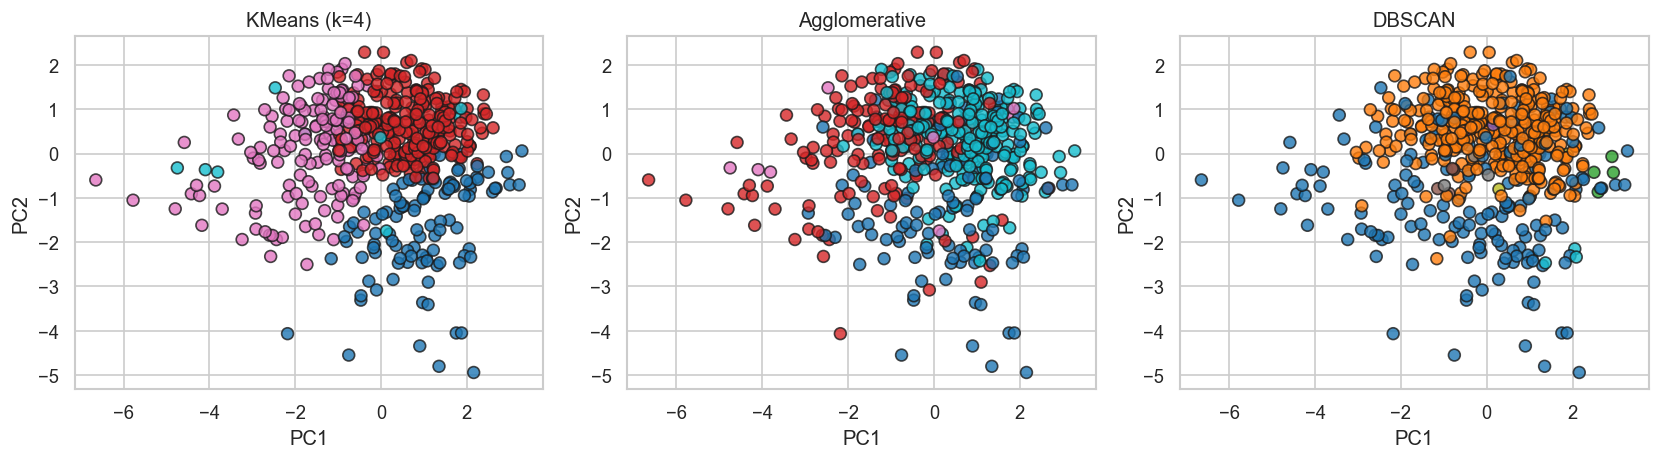

In [9]:
# Matplotlib scatterplots
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['kmeans_label'], cmap='tab10', s=50, edgecolors='k', alpha=0.8)
plt.title(f'KMeans (k={best_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 2)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['agg_label'], cmap='tab10', s=50, edgecolors='k', alpha=0.8)
plt.title('Agglomerative')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 3)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['dbscan_label'], cmap='tab10', s=50, edgecolors='k', alpha=0.8)
plt.title('DBSCAN')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()


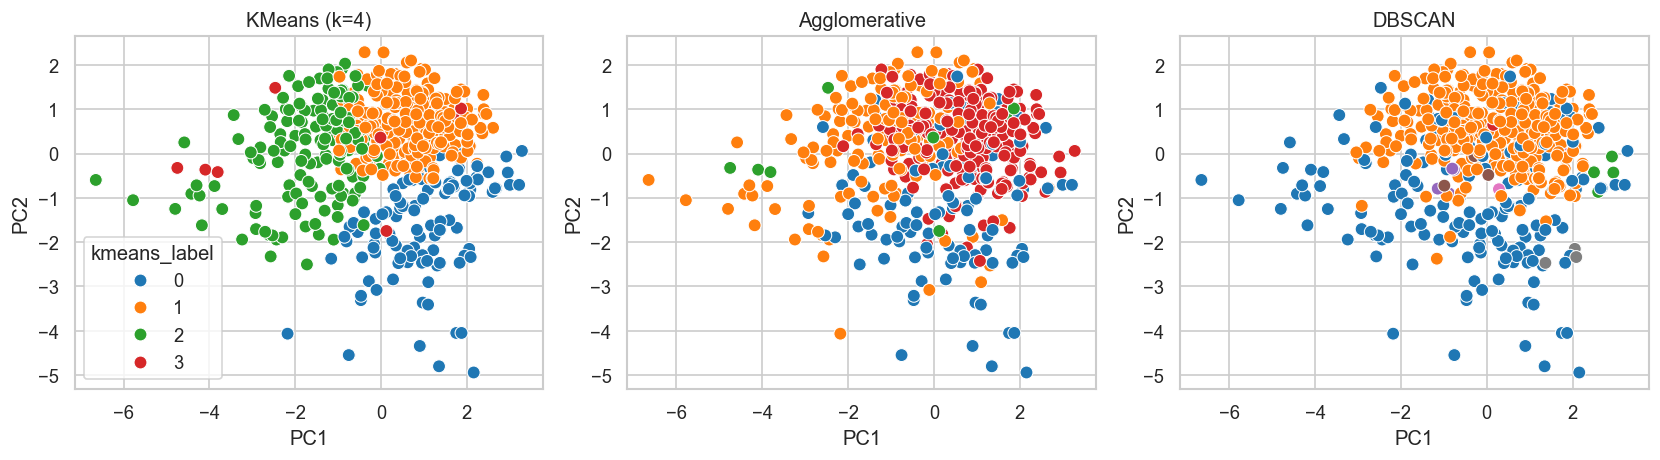

In [10]:
# Seaborn scatterplots
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
sns.scatterplot(ax=axes[0], data=pca_df, x='PC1', y='PC2', hue='kmeans_label', palette='tab10', s=60, edgecolor='white')
axes[0].set_title(f'KMeans (k={best_k})')

sns.scatterplot(ax=axes[1], data=pca_df, x='PC1', y='PC2', hue='agg_label', palette='tab10', s=60, edgecolor='white', legend=False)
axes[1].set_title('Agglomerative')

sns.scatterplot(ax=axes[2], data=pca_df, x='PC1', y='PC2', hue='dbscan_label', palette='tab10', s=60, edgecolor='white', legend=False)
axes[2].set_title('DBSCAN')

plt.tight_layout()
plt.show()


In [11]:
# Plotly interactive scatterplots
hover_data = [hover_col] if hover_col is not None else None

fig_kmeans = px.scatter(pca_df, x='PC1', y='PC2', color='kmeans_label',
                        hover_name=hover_col if hover_col is not None else None,
                        hover_data=hover_data, title=f'Interactive KMeans (k={best_k})')
fig_kmeans.update_traces(marker=dict(size=9, line=dict(width=0.5, color='DarkSlateGrey')))
fig_kmeans.show()

fig_agg = px.scatter(pca_df, x='PC1', y='PC2', color='agg_label',
                     hover_name=hover_col if hover_col is not None else None,
                     hover_data=hover_data, title='Interactive Agglomerative')
fig_agg.update_traces(marker=dict(size=9, line=dict(width=0.5, color='DarkSlateGrey')))
fig_agg.show()

fig_db = px.scatter(pca_df, x='PC1', y='PC2', color='dbscan_label',
                    hover_name=hover_col if hover_col is not None else None,
                    hover_data=hover_data, title='Interactive DBSCAN')
fig_db.update_traces(marker=dict(size=9, line=dict(width=0.5, color='DarkSlateGrey')))
fig_db.show()


## Discussion and Interpretation

Once we’ve visualized the clusters, we’ll interpret the results:

- Which algorithm produced the clearest separation?
- Do the clusters correspond to any meaningful musical patterns?
- How do the PCA components help visualize these differences?
- If DBSCAN labeled many points as noise (label `-1`), what might that say about the dataset’s structure?

### Reflection on Visualization Tools
- **Matplotlib** offers full control and is ideal for static academic figures.  
- **Seaborn** creates polished visuals quickly, great for reports and exploration.  
- **Plotly** adds interactivity, making it easier to inspect specific songs or regions in the plot.




## Personal Observations

### Notable clustering patterns
The clustering results revealed several meaningful groupings within the Nigerian songs dataset.  
KMeans and Agglomerative Clustering both identified clear separations between high-energy, danceable tracks and softer, acoustic or mellow ones.  
A smaller cluster appeared to consist of songs with moderate tempo and energy — possibly mid-tempo Afro-pop or R&B tracks.  
DBSCAN, on the other hand, produced fewer distinct groups and labeled several songs as noise, which suggests that some tracks don’t strongly fit into any dense region of the feature space.

### Features driving the clusters
The main features influencing the separation seemed to be **tempo**, **energy**, and **loudness**.  
Songs with high tempo and loudness tended to cluster together, representing upbeat or club-style tracks.  
Meanwhile, lower energy and softer loudness values were common in a second group that likely corresponds to ballads or acoustic pieces.  
Other features like **danceability** and **valence** also appeared to contribute to more subtle distinctions within the larger groups.

### Visualization preferences
Among the three visualization libraries:
- **Seaborn** provided the clearest visual balance — easy to interpret, with neat color separation and smooth legends.
- **Matplotlib** was great for layout control but required more manual styling.
- **Plotly** stood out for interactivity. Hovering over individual points made it easier to see song names and understand which songs belonged to which cluster.

Overall, Plotly made exploration more intuitive, while Seaborn worked best for presentation.

### Final thoughts
The **KMeans algorithm** offered the most consistent and interpretable results, showing balanced clusters with a high silhouette score.  
**Agglomerative Clustering** performed similarly but was slightly less distinct visually.  
**DBSCAN** was useful for identifying potential outliers but didn’t capture the structure as clearly.

For this dataset, a combination of **KMeans clustering** and **Seaborn visualization** provides the best mix of clarity, simplicity, and interpretability.  
Plotly can be used as an interactive supplement for exploring individual tracks in more depth.


In [12]:
# (Optional) Save the PCA + labels table for reference
pca_df.to_csv('nigerian-songs_pca_clusters.csv', index=False)
display(pca_df.head())


,PC1,PC2,name,kmeans_label,dbscan_label,agg_label
0,-4.747652,-0.324836,Sparky,3,-1,2
1,-1.334754,0.324842,shuga rush,2,-1,0
2,-1.861778,1.070272,LITT!,2,0,1
3,-2.189183,0.729522,Confident / Feeling Cool,2,0,1
4,-1.768084,0.433907,wanted you,3,-1,2
